In [1]:
# imports
# Generic
import os
from pathlib import Path
import html

# Plotting
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Specify plotly renderer for vscode
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch
import pandas as pd

# Transformer Stuff
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Our Code
from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import MazeTokenizer, SPECIAL_TOKENS, HuggingMazeTokenizer
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.evaluation.eval_model import load_model_with_configs 
from maze_transformer.evaluation.eval_model import decode_maze_tokens_to_coords

from scripts.create_dataset import create_dataset
from scripts.train_model import train_model

%load_ext autoreload
%autoreload 2

In [2]:
# -- Configuration --
# Set seed for reproducibility
seed = 42
_= torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DARK_MODE = True
if DARK_MODE:
    pio.templates.default = "plotly_dark"
    plt.style.use("dark_background")
    
# load model and configs - this should point towards a directory containing a run
dataset_path = Path("../data/maze/g3-n5-debugging/")
run_path = dataset_path / "g3-n5-debugging_tiny-v1_2023-03-05-17-29-11"
# run_path = Path("../data/maze/g5-n1000000")
# If you don't have any runs, you can use:
# try:
#     create_dataset(path_base="../data/maze/", n_mazes=5, grid_n=3, name="debugging")
# except FileExistsError:
#     print(f'{Path("../data/maze/debugging").as_posix()} already exists, skipping...')
#     pass
# train_model(basepath="../data/maze/g3-n5-debugging")

In [3]:
# We won't be training any models
torch.set_grad_enabled(False) 


# Get latest model
model_path = list(sorted(run_path.glob('**/model.final.pt'), key=os.path.getmtime))
if len(model_path) == 0: # Get latest checkpoint instead
    model_path = list(sorted(run_path.glob('**/checkpoints/model.iter_*.pt'), key=os.path.getmtime))
model_path = model_path[-1].resolve()

model, cfg = load_model_with_configs(model_path)

In [4]:
# generate a maze
grid_n: int = cfg.dataset_cfg.grid_n
maze: LatticeMaze = LatticeMazeGenerators.gen_dfs((grid_n, grid_n))
c_start = (0, 0)
c_end = (grid_n - 1, grid_n - 1)

# solve the maze explicitly
path_true = np.array(maze.find_shortest_path(
	c_start = c_start,
	c_end = c_end,
))

solved_maze: MazeTokenizer = MazeTokenizer(
	maze=maze,
	solution=path_true,
)

# tokenize the maze
maze_only_tokens: list[str] = solved_maze.as_tokens(cfg.dataset_cfg.node_token_map , solution = False) + [ SPECIAL_TOKENS["start_path"] ]

print("maze tokens:", maze_only_tokens)

array = model.to_tokens(" ".join(maze_only_tokens), prepend_bos=False)

maze tokens: ['<ADJLIST_START>', '(0,1)', '<-->', '(0,0)', ';', '(1,1)', '<-->', '(1,2)', ';', '(2,0)', '<-->', '(1,0)', ';', '(0,2)', '<-->', '(0,1)', ';', '(1,1)', '<-->', '(2,1)', ';', '(2,0)', '<-->', '(2,1)', ';', '(1,0)', '<-->', '(0,0)', ';', '(1,2)', '<-->', '(2,2)', ';', '<ADJLIST_END>', '<TARGET_START>', '(2,2)', '<TARGET_END>', '<START_PATH>']


In [5]:
# have the model predict some tokens
context_str: list[str] = maze_only_tokens

# escape for html
context_str = [ html.escape(t) for t in context_str ]

array_tensor = torch.tensor(array).long().to(device)
with torch.no_grad():
	logits, cache = model.run_with_cache(array_tensor)

attentions = [w for k, w in cache.items() if 'hook_pattern' in k]
print(f"{logits.shape = }\n{len(attentions) = }\n{[x.shape for x in attentions] = }")

# `output.attentions` is a tuple of tensors, where each element of the tuple corresponds to a layer. 
#  The tensor has dimensions (1, n_heads, n_positions, n_positions)


logits.shape = torch.Size([1, 38, 18])
len(attentions) = 4
[x.shape for x in attentions] = [torch.Size([1, 2, 38, 38]), torch.Size([1, 2, 38, 38]), torch.Size([1, 2, 38, 38]), torch.Size([1, 2, 38, 38])]


/tmp/ipykernel_2401784/1285469696.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [6]:
from circuitsvis.attention import attention_heads
n_layers: int = len(attentions)
n_heads: int = attentions[0].shape[1]
n_tokens: int = attentions[0].shape[2]
attention_to_plot = torch.concatenate(attentions, dim=0).reshape(-1, n_tokens, n_tokens)
attention_head_names = [f"Layer {i} Head {j}" for i in range(n_layers) for j in range(n_heads)]
attention_heads(attention_to_plot,maze_only_tokens, attention_head_names)

In [7]:
from circuitsvis.tokens import colored_tokens_multi
FROM_TOKEN = -1 # Look at attention from this token position to the rest of the sequence
attentions_from_token = torch.concatenate([w[0, :, FROM_TOKEN, :] for w in attentions], dim=0)
colored_tokens_multi(context_str, attentions_from_token.T, labels=attention_head_names)

FAIL: Sampled a path - No coordinate token found before EOS
SUCCESS: Model predicted the path:
['(0,0)', '(2,2)', '(1,1)', '(1,1)', '<END_PATH>']


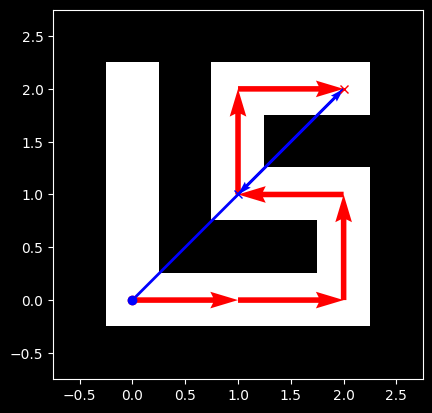

In [9]:
def prediction_contained_a_coordinate_token(tokens: list[str], tokenizer: HuggingMazeTokenizer) -> bool:
	"""Check if the prediction contains a coordinate token"""
	for t in tokens:
		if t not in list(tokenizer.special_tokens_map.values()) + tokenizer.additional_special_tokens:
			return True
	print("FAIL: Sampled a path - No coordinate token found before EOS")
	return False

predicted_tokens = []
while not prediction_contained_a_coordinate_token(predicted_tokens, model.tokenizer):
	predictions = model.generate(array_tensor, max_new_tokens=50, stop_at_eos=True, verbose=False)
	predicted_tokens = model.to_str_tokens(predictions)[len(maze_only_tokens):]
print("SUCCESS: Model predicted the path:")
print(predicted_tokens)

path_predicted: list[tuple[int,int]] = decode_maze_tokens_to_coords(
	predicted_tokens,
	mazedata_cfg = cfg.dataset_cfg, 
	when_noncoord = "skip",
)

# plot the maze and both solutions
# for label, fmt, color, path in paths
plot_multi_paths(
	maze = maze,
	paths = [
		PathFormat(path_true, "true", "-", "red", {'width': 0.015}),
		PathFormat(np.array(path_predicted), "predicted", ":", "blue", {}),
	],
)